In [1]:
%matplotlib notebook

C:\Users\shahmoradia\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shahmoradia\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\shahmoradia\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\shahmoradia\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import paramonte as pm
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()

In [3]:
url = ""#"http://www.cdslab.org/recipes/programming/regression-censored-gaussian-data/"
df = pd.read_csv(url+"data.csv", header=None)

In [4]:
df.head()

,0
0,-0.739019
1,-0.564669
2,0.207799
3,-1.325145
4,-1.838084


In [5]:
df.count()

0    4210
dtype: int64

<IPython.core.display.Javascript object>


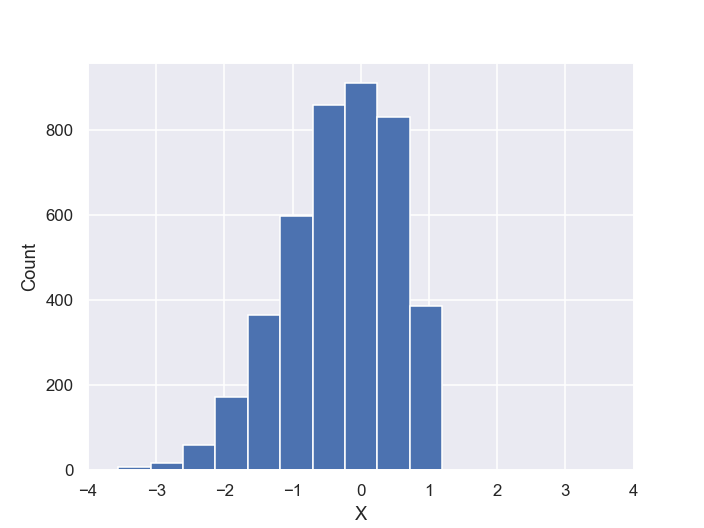

In [6]:
# plot histogram of data
x = df.values

fig = plt.figure()
ax = fig.gca()
ax.hist(x)
ax.set_xlim([-4,4])
ax.set_xlabel("X")
ax.set_ylabel("Count")
plt.show()

In [7]:
#getModelLogPDF(x = 0, meanG = 0, logStdG = 1, meanC = 0.5, logStdC = .1)

In [8]:
#np.exp(getLogPDF(x = 0, mean = 0, logStd = np.log(1)))

In [9]:
NDATA = len(x)
SQRT_TWO = np.sqrt(2)
from scipy.special import erf
from scipy.integrate import romberg

def getLogLike(params): 
    
    meanG = params[0]
    logStdG = params[1]
    stdG = np.exp(logStdG)

    meanC = params[2]
    logStdC = params[3]
    stdC = np.exp(logStdC)

    # Compute the probability of censiship
    def getCensorshipLogProb(x): return 0.5 + 0.5 * erf( (meanC - x) / (stdC * SQRT_TWO) )

    # Compute the Gaussian probablity of data
    def getNormLogPDF(x): return -np.log(np.sqrt(2*np.pi)) - logStdG - (x - meanG)**2 / (2*stdG**2)

    # Compute the log-probability of data.
    def getModelLogPDF(x): return getNormLogPDF(x) + getCensorshipLogProb(x)

    ##########################################################################
    # Compute the normalization factor of the model such that it becomes a PDF
    ##########################################################################

    # Compute the probability of data.
    def getModelPDF(x): return np.exp(getModelLogPDF(x))
    
    # Get the Gaussian CDF up to a given point, needed for the computation of the normalization factor
    def getNormCDF(x, mean, std): return 0.5 + 0.5 * erf( (x - mean) / (std * SQRT_TWO) )

    def getLogNormalizationFactor():

        print(params)
        threshold = meanC - 4 * stdC
        integralPart1 = getNormCDF(x = threshold, mean = meanG, std = stdG)
        integralPart2 = romberg( function = getModelPDF
                               , a = threshold
                               , b = meanC + 4 * stdC
                               , tol = 1.e-4
                               , divmax = 8
                               )
        return np.log(integralPart1 + integralPart2)
        
    # return thre likelihood
        
    return np.sum(getModelLogPDF(x)) - NDATA * getLogNormalizationFactor()


In [10]:
getLogLike(params = [0, 1, np.log(0.5), 1])

[0, 1, -0.6931471805599453, 1]


-8396.154712048532

In [ ]:
import paramonte as pm
pm.version.interface.dump() # get the version of ParaMonte we are working with
pmpd = pm.ParaDRAM() # create a ParaDRAM sampler object
pmpd.spec.chainSize = 20000 # change the number of sampled points from default 100,000 to 30,000
pmpd.spec.variableNameList = ["meanG","logStdG","meanC","logStdC"]
pmpd.spec.startPointVec = [0,0,np.log(0.5),-1] # ensure the initial starting point of the search for cutoff is good.
pmpd.spec.targetAcceptanceRate = [0.1,0.3] # ensure the MCMC sampling efficiency does not become too large or too small.

# call MCMC sampler

pmpd.runSampler( ndim = 4
               , getLogFunc = getLogLike
               )

In [ ]:
pmpd.readSample()

In [ ]:
# read the resulting sample

sample = pmpd.readSample(renabled = True)[0]

# plot traceplots of the sampled parameters

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.line.ycolumns = colname
    sample.plot.line.outputFile = "traceplot_" + colname
    sample.plot.line()
    sample.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample.plot.line.currentFig.axes.set_ylabel(colname)

# plot the histograms of the sampled parameters

for colname in pmpd.sampleList[0].df.columns:
    print(colname)
    sample.plot.histplot.xcolumns = colname
    sample.plot.histplot.outputFile = "histogram_" + colname
    sample.plot.histplot()
    sample.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")


In [ ]:
np.exp(sample.df.LogStandardDeviation.mean())

In [ ]:
logStd = sample.df.LogStandardDeviation.mean()
mean = sample.df.Average.mean()

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
ax.hist( logx
       , density = True
       )
xval = np.linspace(-4, 4, 100)
yval = np.exp(getLogPDF(xval, mean, logStd))
ax.plot( xval
       , yval
       , color = "r"
       , linewidth = 3
       )
plt.legend(["Censored Data", "Gaussian Best-Fit Line"])
plt.savefig("CensoredDataGaussianFit.png")

In [ ]:
#chain = pmpd.readChain(renabled = True)[0]
chain.plot.contour3()

In [ ]:
chain.plot.lineScatter3()

In [ ]:
sample = pmpd.readSample(renabled = True)[0]
sample.plot.contour3()
sample.plot.lineScatter3()

In [ ]:
"A".replace("","X")

In [ ]:
class Normal():

    def __init__(self, normData):
        self.data = normData
        self.ndata = len(self.data)
        self.maxdata = np.max(self.data)

    def getLogProb(self, data, avg, logStd, cutoff):
        """
        Return the logarithm of the probability density of an input set of x values, 
        given the input parameters (avg,logStd,cutoff) for the Gaussian PDF.
        """
        std = np.exp(logStd)
        return - 2.506628274631000 - logStd - 0.5 * ( (data-avg) / std )**2 - np.log(norm.cdf(cutoff, avg, std))

    def getLogLike(self,param):
        if param[2] < self.maxdata:
            # data cannot be larger than the threshold, 
            # so such parameter set for the Gaussian is impossible
            # therefore return negative infinity as the value of the logLikelihood
            return -1.e300
        else:
            return np.sum( self.getLogProb(self.data, param[0], param[1], param[2]) )

normal = Normal(normData = logx)

In [ ]:
pmpd = pm.ParaDRAM() # create a ParaDRAM sampler object
pmpd.spec.chainSize = 20000 # change the number of sampled points from default 100,000 to 30,000
pmpd.spec.variableNameList = ["Average","LogStandardDeviation","Cutoff"]
pmpd.spec.startPointVec = [0,0,normal.maxdata] # ensure the initial starting point of the search for cutoff is good.
pmpd.spec.targetAcceptanceRate = [0.1,0.2]

# call MCMC sampler

pmpd.runSampler( ndim = 3
               , getLogFunc = normal.getLogLike
               )

In [ ]:
# read the resulting sample
pmpd.readSample()

# plot the sampled variables
for colname in pmpd.sampleList[0].df.columns:
    pmpd.sampleList[0].plot.line.ycolumns = colname
    pmpd.sampleList[0].plot.line.outputFile = "traceplot_" + colname
    pmpd.sampleList[0].plot.line()
    pmpd.sampleList[0].plot.line.currentFig.axes.set_xlabel("MCMC Count")
    pmpd.sampleList[0].plot.line.currentFig.axes.set_ylabel(colname)



In [ ]:
# plot the histograms of the sampled parameters
for colname in pmpd.sampleList[0].df.columns:
    pmpd.sampleList[0].plot.hist.columns = colname
    pmpd.sampleList[0].plot.hist.outputFile = "histogram_" + colname
    pmpd.sampleList[0].plot.hist()
    pmpd.sampleList[0].plot.hist.currentFig.axes.set_xlabel("MCMC Count")
    pmpd.sampleList[0].plot.hist.currentFig.axes.set_ylabel(colname)


In [ ]:
# make interactive plotting possible in Jupyter Notebook

try:
    %matplotlib notebook
except:
    pass

# import visualization and data libraries

import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()

df = pd.read_csv("http://www.cdslab.org/recipes/programming/regression-censored-gaussian-data/data.csv", header=None)
df.head()

# log-transform data so that it can be fit by a Normal distribution

logx = np.double(np.log(df.iloc[:,0]))

# plot histogram of log(data)

fig = plt.figure()
ax = fig.gca()
ax.hist(logx)
ax.set_xlim([-4,4])
ax.set_xlabel("Log( X )")
ax.set_ylabel("Count")
plt.show()

# generate the Normal class containing the log-likelihood function

class Normal():

    def __init__(self, normData):
        self.data = normData
        self.ndata = len(self.data)
        self.maxdata = np.max(self.data)

    def getLogProb(self, data, avg, logStd, cutoff):
        """
        Return the logarithm of the probability density of an input set of x values, 
        given the input parameters (avg,logStd,cutoff) for the Gaussian PDF.
        """
        std = np.exp(logStd)
        return -0.9189385332 - logStd - 0.5 * ( (data-avg) / std )**2 - np.log(norm.cdf(cutoff, avg, std))

    def getLogLike(self,param):
        if param[2] < self.maxdata:
            # data cannot be larger than the threshold, 
            # so such parameter set for the Gaussian is impossible
            # therefore return negative infinity as the value of the logLikelihood
            return -1.e300
        else:
            return np.sum( self.getLogProb(self.data, param[0], param[1], param[2]) )

normal = Normal(normData = logx)

# sample the log-likelihood function via the ParaDRAM MCMC sampler

import paramonte as pm
pmpd = pm.ParaDRAM() # create a ParaDRAM sampler object
pmpd.spec.chainSize = 20000 # change the number of sampled points from default 100,000 to 30,000
pmpd.spec.variableNameList = ["Average","LogStandardDeviation","Cutoff"]
pmpd.spec.startPointVec = [0,0,normal.maxdata] # ensure the initial starting point of the search for cutoff is good.
pmpd.spec.targetAcceptanceRate = [0.1,0.3] # ensure the MCMC sampling efficiency does not become too large or too small.

# call the MCMC sampler

pmpd.runSampler( ndim = 3
               , getLogFunc = normal.getLogLike
               )

# read the resulting sample

sample = pmpd.readSample(renabled = True)[0]

# plot traceplots of the sampled parameters

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.line.ycolumns = colname
    sample.plot.line.outputFile = "traceplot_" + colname
    sample.plot.line()
    sample.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample.plot.line.currentFig.axes.set_ylabel(colname)

# plot the histograms of the sampled parameters

for colname in pmpd.sampleList[0].df.columns:
    sample.plot.histplot.columns = colname
    sample.plot.histplot.outputFile = "histogram_" + colname
    sample.plot.histplot()
    sample.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")

pmpd.sample.df.mean()

In [ ]:
logStd = sample.df.LogStandardDeviation.mean()
mean = sample.df.Average.mean()

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
ax.hist( logx
       , density = True
       )
xval = np.linspace(-4, 4, 100)
yval = np.exp(getLogPDF(xval, mean, logStd))
ax.plot( xval
       , yval * 5.2/4
       , color = "r"
       , linewidth = 3
       )
ax.set_xlim([-4.5, 4.5])
ax.set_xlabel("Log( X )")
ax.set_ylabel("Probability Density Function")
plt.legend(["Censored Data", "Truncated-Gaussian Best-Fit"])
plt.tight_layout()
plt.savefig("CensoredDataCensoredNormalFit.png")

In [ ]:
pmpd.sampleList[0].df.mean()

In [ ]:
np.max(logx)

In [ ]:
norm.cdf(cutoff, avg, std)

In [ ]:
pmpd.sampleList[0].plot.hist.columns